In [3]:
conda install pandas

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mpl-finance

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m

In [1315]:
# Read the file of RTSI index definitions
data=pd.read_csv('SBER_190801_191231.txt', sep=';' , header=0, names=['Ticker','Per','Date','Time','Open','High','Low', 'Close', 'Vol'])
data
# sep=';' ,
# ,'Openint'
P = 20
D = 2
N = 14

In [1316]:
# creating Bollinger Bands DataFrame
Bolbands = pd.DataFrame()

# Creating Lines

# parameters
period = P
d = D

l = len(data.Close)

# ML
ML=[]
for i in range (period-1, l):
    arr = []
    for a in range (i-(period-1), i):
        arr.append(data.Close[a])
    ML.append(np.mean(arr))
    arr.clear()
Bolbands['ML'] = ML

# Std
Std =[]
for i in range (0, period+1):
    Std.append((data.Close[i]-Bolbands.ML[0])**2)
for i in range (period, l):
    Std.append((data.Close[i]-Bolbands.ML[i-(period-1)])**2)
print('lengh Std: ', len(Std))

# BL
BL=[]
for i in range (period-1, l):
    arr = []
    for a in range (i-(period-1),i):
        arr.append(Std[a])
    BL.append(ML[i-(period-1)]-(d*np.sqrt(np.mean(arr))))
    arr.clear()
Bolbands['BL']=BL

# TL
TL=[]
for i in range (period-1, l):
    arr = []
    for a in range (i-(period-1),i):
        arr.append(Std[a])
    TL.append(ML[i-(period-1)]+(d*np.sqrt(np.mean(arr))))
    arr.clear()
Bolbands['TL']=TL

Bolbands

lengh Std:  964


,ML,BL,TL
0,226.660000,220.461746,232.858254
1,226.294211,220.216335,232.372086
2,225.935789,219.961406,231.910173
3,225.601579,219.723076,231.480082
4,225.268421,219.464540,231.072302
...,...,...,...
939,250.100526,246.201795,253.999258
940,250.441579,246.282864,254.600294
941,250.816842,246.045117,255.588567
942,251.238947,246.002430,256.475465


In [1317]:
# Prices for plot
data1 = data[['Date','Open', 'High','Low','Close']][period-1:]
data1

,Date,Open,High,Low,Close
19,05/08/19,222.53,223.99,222.00,223.69
20,05/08/19,223.68,224.00,222.81,223.69
21,05/08/19,223.66,223.96,222.94,223.80
22,05/08/19,223.79,223.90,222.99,223.28
23,05/08/19,223.31,223.63,221.80,221.96
...,...,...,...,...,...
958,30/12/19,253.05,255.25,252.97,255.21
959,30/12/19,255.20,256.00,254.86,255.16
960,30/12/19,255.16,255.94,254.53,255.62
961,30/12/19,255.62,255.65,254.55,254.81


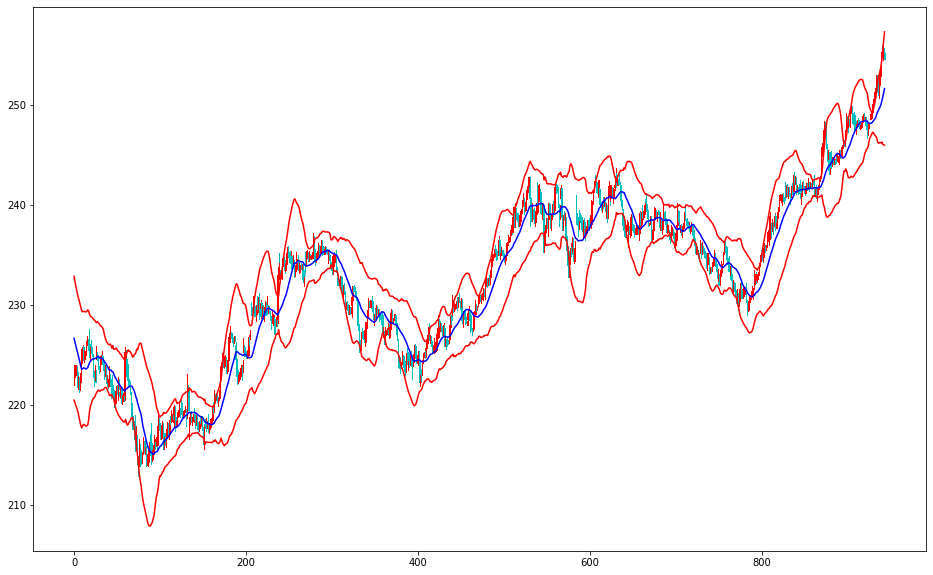

In [1318]:
# Bollinger bonds plot
from mpl_finance import candlestick2_ohlc
prices=pd.DataFrame()
prices = data[['Open', 'High','Low','Close']][period-1:]

fig, ax = plt.subplots(figsize=(16,10))
candlestick2_ohlc(ax, prices.Open, prices.High, prices.Low, prices.Close,
                  width=0.6, colorup='r', colordown='c', alpha=1)
plt.plot(Bolbands.ML, color='blue')
plt.plot(Bolbands.BL, color='red')
plt.plot(Bolbands.TL, color='red')

In [1319]:
# Сигналы индекса полос Боллинджера
signals=pd.DataFrame()
signals['Date'] = data1.Date
append_me=[]
for i in range ((period-1), len(signals.Date)+(period-1)):
    if (prices.Open[i] or prices.Close[i])>Bolbands.TL[i-(period-1)]:
        append_me.append('Sell')
    else:
        if (prices.Open[i] or prices.Close[i])<Bolbands.BL[i-(period-1)]:
            append_me.append('Buy')
        else:
            append_me.append(0)

signals['Signal']=append_me
signals

,Date,Signal
19,05/08/19,0
20,05/08/19,0
21,05/08/19,0
22,05/08/19,0
23,05/08/19,0
...,...,...
958,30/12/19,0
959,30/12/19,Sell
960,30/12/19,0
961,30/12/19,0


In [1320]:
# Buy/Sell Bot for Bollinger bands

Bud = 10000 # изначальный бюджет
bud = Bud # текущий бюджет
val = 0 # количество акций в наличии

trend = 'up' # тренд по умолчанию
timer_up=0 # таймер срочной покупки для восходящего тренда
timer_d=0 # таймер срочной продажи для нисходящего тренда
lag_d=0 # оператор для сохранения цены 
delta=[]
accuracy = len(signals.Date)//6 # (>0) сколько периодов учитывается для анализа тренда
print('Accuracy for trend analisys: ', accuracy)

take_profit_value = (np.max(data.High)-np.min(data.Low))/5
# 200 # take profit value

stop_loss_value = take_profit_value/2
# 100 # stop loss value


compare=0

# BOT
for i in range (period, len(signals.Date)+(period-1)):

    # анализ тренда
    up=0
    down=0
    if i>19:
        delta_ML=np.sign(Bolbands.ML[i-(period-1)]-Bolbands.ML[i-period])
        delta.append(delta_ML)
    if len(delta)>accuracy:
        for a in delta:
            if a>0:
                up+=1
            else:
                if a<0:
                    down+=1
        if up>down:
            trend = 'up'
        else:
            trend = 'down'
    # действия при нисходящем тренде
    if trend == 'down':
        if (data.Open[i]-timer_d)>=take_profit_value and timer_d!=0:
            bud = bud + val*data.Open[i]
            compare=0
            val=0
            timer_d = 0
            lag_d=0
            rev = ((bud-Bud)/Bud)*100
            print('TAKE-PROFIT INTERRUPT: DOWN-TREND')
            print ('Продажа', '\n', bud,'\n','Цена', data.Open[i],'\n', 'Прибыль: ', rev, '%','\n', i,'\n')
        if timer_d>data.Open[i] and timer_d!=0:
            lag_d+=1
            timer_d=data.Open[i-lag_d]
    # действия при нисходящем тренде       
    if trend =='up':
        if (timer_up-data.Open[i])>=take_profit_value and timer_up!=0:
            k=bud//data.Open[i]
            bud = bud - k*data.Open[i]
            compare = data.Open[i]
            val+=k
            timer_up = 0
            lag_up=0
            print('TAKE-PROFIT INTERRUPT: UP-TREND')
            print ('Покупка', '\n', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  i,'\n')
        if timer_up<data.Open[i] and timer_up!=0:
            lag_up+=1
            timer_up=data.Open[i-lag_up]
 

    # покупка или продажа
    if signals.Signal[i]!= 0:
        if i>((period-1)+accuracy):
            if signals.Signal[i-1] == 'Buy'and bud> data.Open[i] and compare==0: # Покупка
                k=bud//data.Open[i]
                bud = bud - k*data.Open[i]
                compare = data.Open[i]
                val+=k
                print('Покупка: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  i,'\n')
                if val!=0 and timer_d==0:
                    timer_d = data.Open[i]
            else:
                if signals.Signal[i-1] =='Sell'and val!=0 and compare<data.Open[i]: # Продажа
                    bud = bud + val*data.Open[i]
                    compare=0
                    val=0
                    rev = ((bud-Bud)/Bud)*100
                    print('Продажа: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')
                    if bud<data.Open[i] and timer_up==0:
                        timer_up = data.Open[i]
    
    # stop loss
    arr=[data.Open[i],data.Close[i]]
    if (timer_d-np.mean(arr))>stop_loss_value:
        bud = bud + val*data.Open[i]
        compare=0
        val=0
        timer_d = 0
        lag_d=0
        rev = ((bud-Bud)/Bud)*100
        print('STOP LOSS INTERRUPT')
        print ('Продажа', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')
        arr=0
    
    # Окончательная продажа
    if data.Close[i]==data.Close[len(signals.Date)+(period-2)] and val!=0:
        bud = bud + val*data.Open[i]
        val=0
        rev = ((bud-Bud)/Bud)*100
        print('Окончательная продажа: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')

        
# Результаты
rev = ((bud-Bud)/Bud)*100
print('RESULTS (Bollinger bands):')
print('Input: ', Bud)
print('Result: ', round(bud))
print('Return: ', round(bud-Bud))
print('Return in %: ', round(rev,2), '%')

Accuracy for trend analisys:  157
Покупка:  42.0  акций 
 204.34000000000015 
 Цена 233.23 
 320 

STOP LOSS INTERRUPT
Продажа 
 9780.34 
 Цена 228.0 
 Прибыль:  -2.1965999999999983 % 
 350 

Покупка:  43.0  акций 
 148.77000000000044 
 Цена 223.99 
 399 

Продажа:  0  акций 
 9942.02 
 Цена 227.75 
 Прибыль:  -0.5797999999999957 % 
 432 

Покупка:  41.0  акций 
 148.35000000000036 
 Цена 238.87 
 658 

Продажа:  0  акций 
 10195.400000000001 
 Цена 245.05 
 Прибыль:  1.9540000000000144 % 
 889 

RESULTS (Bollinger bands):
Input:  10000
Result:  10195.0
Return:  195.0
Return in %:  1.95 %


In [1321]:
# Результат
import datetime as DT
date_start = DT.datetime.strptime(data.Date[0], '%d/%m/%y').date()
date_end = DT.datetime.strptime(data.Date[len(data.Date)-1], '%d/%m/%y').date()
delta_price = np.max(data.High)-np.min(data.Low)

print('РЕЗУЛЬТАТЫ:')
print('Тикер: ', data.Ticker[0])
print('Период: ', date_end-date_start)
print('Выборка: ', len(data.Close), ' периодов')
print('Таймфрейм: ', data.Per[0],'\n')
print('Изменение цены за период:', round(delta_price,2))
print('Изменение цены за период в %: ', round((delta_price/np.mean(data.Close))*100,2), '%')
print('Прибыль: ', round(bud-Bud), ' рублей')
print('Прибыль в %: ', round(rev,2), '%','\n')
# print('-> Изменение прибыли в отношении изменения цены: ',round(rev/((delta_price/np.mean(data.Close))*100)*100,2),'%','\n')
print('Выборка для прогноза тренда: ', accuracy, ' периодов')
print('Выборка для работы бота : ', len(data.Close)-accuracy, ' периодов')
print('Stop Loss maximum value: ', stop_loss_value, ' рублей')
print('Take profit value: ', take_profit_value, ' рублей')


РЕЗУЛЬТАТЫ:
Тикер:  SBER
Период:  151 days, 0:00:00
Выборка:  963  периодов
Таймфрейм:  60 

Изменение цены за период: 43.12
Изменение цены за период в %:  18.55 %
Прибыль:  195.0  рублей
Прибыль в %:  1.95 % 

Выборка для прогноза тренда:  157  периодов
Выборка для работы бота :  806  периодов
Stop Loss maximum value:  4.312  рублей
Take profit value:  8.624  рублей


962
963


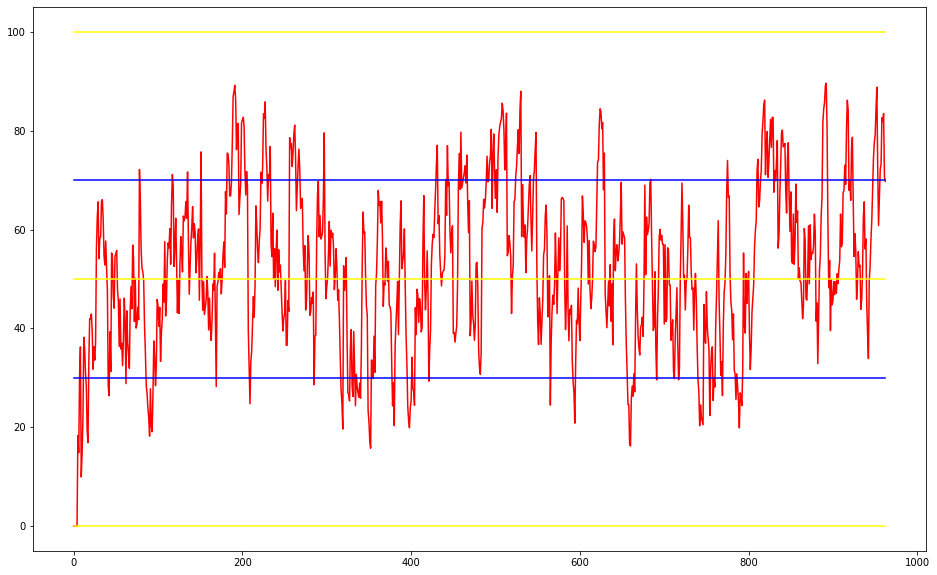

In [1309]:
# creating RSI index DataFrame and plot
RSI = pd.DataFrame()
# parameters
n = N # оптимальный период осцилятора RSI
alpha = 2/(n+1)

# изменения цен
delta_p=[]
for i in range (1,len(data.Close)):
    delta_p.append(data.Close[i]-data.Close[i-1])
ups=[]
downs=[]
for i in range (0,len(delta_p)):
    if np.sign(delta_p[i])>0:
        ups.append(delta_p[i])
    else:
        ups.append(0)
    if np.sign(delta_p[i])<0:
        downs.append(m.fabs(delta_p[i]))
    else:
        downs.append(0)
print(len(ups))
print(len(data.Close))
# EMA
EMA_U=[]
EMA_D=[]
EMA_U.append(ups[0])
EMA_D.append(downs[0])
for i in range(1, len(ups)):
    EMA_U.append(EMA_U[i-1]+alpha*(ups[i]-EMA_U[i-1]))
    EMA_D.append(EMA_D[i-1]+alpha*(downs[i]-EMA_D[i-1]))
    
# RSI
RS=[]
for i in range(0, len(ups)):
    if EMA_D[i]!=0:
        RS.append(EMA_U[i]/EMA_D[i])
    else:
        RS.append(0)
rsi=[]
rsi.append(0)
for i in range(0, len(ups)):
    rsi.append(100-(100/(1+RS[i])))   

line30=[]
line50=[]
line70=[]
line0=[]
line100=[]
for i in range (0, len(data.Close)):
    line30.append(30)
    line50.append(50)
    line70.append(70)
    line0.append(0)
    line100.append(100)
RSI['RSI']=rsi
RSI['0']=line0
RSI['30']=line30
RSI['50']=line50
RSI['70']=line70
RSI['100']=line100

# plot
plt.subplots(figsize=(16,10))
plt.plot(RSI.RSI, color='red')
plt.plot(RSI['0'], color='yellow')
plt.plot(RSI['30'], color='blue')
plt.plot(RSI['50'], color='yellow')
plt.plot(RSI['70'], color='blue')
plt.plot(RSI['100'], color='yellow')

In [1310]:
# Сигналы индекса RSI
signalsrsi=pd.DataFrame()
signalsrsi['Date'] = data1.Date
append_me=[]
for i in range ((period-1), len(data.Close)):
    if RSI.RSI[i]>=70:
        append_me.append('Sell')
    else:
        if RSI.RSI[i]<=30:
            append_me.append('Buy')
        else:
            append_me.append(0)

signalsrsi['Signal_RSI']=append_me
signalsrsi

,Date,Signal_RSI
19,05/08/19,0
20,05/08/19,0
21,05/08/19,0
22,05/08/19,0
23,05/08/19,0
...,...,...
958,30/12/19,Sell
959,30/12/19,Sell
960,30/12/19,Sell
961,30/12/19,Sell


In [1314]:
# Bot for Bollinger bands and RSI

Bud = 10000 # изначальный бюджет
bud = Bud # текущий бюджет
val = 0 # количество акций в наличии

trend = 'down' # тренд по умолчанию
timer_up=0 # таймер срочной покупки для восходящего тренда
timer_d=0 # таймер срочной продажи для нисходящего тренда
lag_d=0 # счет дл
delta=[]
accuracy = len(signals.Date)//6 # (>0) сколько периодов учитывается для анализа тренда

print('Accuracy for trend analisys: ', accuracy)

take_profit_value = 10
(np.max(data.High)-np.min(data.Low))/5
# take profit value

stop_loss_value = 5
# take_profit_value/2
# stop loss value

compare=0

# BOT
for i in range (period, len(signals.Date)+(period-1)):

    # анализ тренда
    up=0
    down=0
    if i>19:
        delta_ML=np.sign(Bolbands.ML[i-(period-1)]-Bolbands.ML[i-period])
        delta.append(delta_ML)
    if len(delta)>accuracy:
        for a in delta:
            if a>0:
                up+=1
            else:
                if a<0:
                    down+=1
        if up>down:
            trend = 'up'
        else:
            trend = 'down'
    # действия при нисходящем тренде
    if trend == 'down':
        if (data.Open[i]-timer_d)>=take_profit_value and timer_d!=0:
            bud = bud + val*data.Open[i]
            compare=0
            val=0
            timer_d = 0
            lag_d=0
            rev = ((bud-Bud)/Bud)*100
            print('TAKE-PROFIT INTERRUPT: DOWN-TREND')
            print ('Продажа', '\n', bud,'\n','Цена', data.Open[i],'\n', 'Прибыль: ', rev, '%','\n', i,'\n')
        if timer_d>data.Open[i] and timer_d!=0:
            lag_d+=1
            timer_d=data.Open[i-lag_d]
    # действия при нисходящем тренде       
    if trend =='up':
        if (timer_up-data.Open[i])>=take_profit_value and timer_up!=0:
            k=bud//data.Open[i]
            bud = bud - k*data.Open[i]
            compare = data.Open[i]
            val+=k
            timer_up = 0
            lag_up=0
            print('TAKE-PROFIT INTERRUPT: UP-TREND')
            print ('Покупка', '\n', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  i,'\n')
        if timer_up<data.Open[i] and timer_up!=0:
            lag_up+=1
            timer_up=data.Open[i-lag_up]
 

    # покупка или продажа
    if signals.Signal[i]!= 0:
        if i>((period-1)+accuracy):
            if signals.Signal[i-1] == 'Buy' and signalsrsi.Signal_RSI[i-1] == 'Buy' and bud>data.Open[i] and compare==0: # Покупка
                k=bud//data.Open[i]
                bud = bud - k*data.Open[i]
                compare = data.Open[i]
                val+=k
                print('Покупка: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  i,'\n')
                if val!=0 and timer_d==0:
                    timer_d = data.Open[i]
            else:
                if signals.Signal[i-1] =='Sell'and signalsrsi.Signal_RSI[i-1] == 'Sell' and val!=0 and compare<data.Open[i]: # Продажа
                    bud = bud + val*data.Open[i]
                    compare=0
                    val=0
                    rev = ((bud-Bud)/Bud)*100
                    print('Продажа: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')
                    if bud<data.Open[i] and timer_up==0:
                        timer_up = data.Open[i]
    
    # stop loss
    arr=[data.Open[i],data.Close[i]]
    if (timer_d-np.mean(arr))>stop_loss_value:
        bud = bud + val*data.Open[i]
        compare=0
        val=0
        timer_d = 0
        lag_d=0
        rev = ((bud-Bud)/Bud)*100
        print('STOP LOSS INTERRUPT')
        print ('Продажа', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')
        arr=0
    
    # Окончательная продажа
    if data.Open[i]==data.Open[len(signals.Date)+(period-2)] and val!=0:
        bud = bud + val*data.Open[i]
        val=0
        rev = ((bud-Bud)/Bud)*100
        print('Окончательная продажа: ', val,' акций', '\n', bud,'\n','Цена', data.Open[i],'\n',  'Прибыль: ', rev, '%','\n', i,'\n')

# Результаты
rev = ((bud-Bud)/Bud)*100
print('RESULTS (both indexes):')
print('Input: ', Bud)
print('Result: ', round(bud))
print('Return: ', round(bud-Bud))
print('Return in %: ', round(rev,2), '%')

Accuracy for trend analisys:  157
Покупка:  42.0  акций 
 204.34000000000015 
 Цена 233.23 
 320 

STOP LOSS INTERRUPT
Продажа 
 9780.34 
 Цена 228.0 
 Прибыль:  -2.1965999999999983 % 
 350 

Покупка:  43.0  акций 
 148.77000000000044 
 Цена 223.99 
 399 

Продажа:  0  акций 
 9942.02 
 Цена 227.75 
 Прибыль:  -0.5797999999999957 % 
 432 

Покупка:  41.0  акций 
 148.35000000000036 
 Цена 238.87 
 658 

Продажа:  0  акций 
 10195.400000000001 
 Цена 245.05 
 Прибыль:  1.9540000000000144 % 
 889 

RESULTS (both indexes):
Input:  10000
Result:  10195.0
Return:  195.0
Return in %:  1.95 %


In [1312]:
# Результат
import datetime as DT
date_start = DT.datetime.strptime(data.Date[0], '%d/%m/%y').date()
date_end = DT.datetime.strptime(data.Date[len(data.Date)-1], '%d/%m/%y').date()
delta_price = np.max(data.High)-np.min(data.Low)

print('РЕЗУЛЬТАТЫ (два индекса):')
print('Тикер: ', data.Ticker[0])
print('Период: ', date_end-date_start)
print('Выборка: ', len(data.Close), ' периодов')
print('Таймфрейм: ', data.Per[0],'\n')
print('Изменение цены за период:', round(delta_price,2))
print('Изменение цены за период в %: ', round((delta_price/np.mean(data.Close))*100,2), '%')
print('Прибыль: ', round(bud-Bud), ' рублей')
print('Прибыль в %: ', round(rev,2), '%','\n')
# print('-> Изменение прибыли в отношении изменения цены: ',round(rev/((delta_price/np.mean(data.Close))*100)*100,2),'%','\n')
print('Выборка для прогноза тренда: ', accuracy, ' периодов')
print('Выборка для работы бота : ', len(data.Close)-accuracy, ' периодов')
print('Stop Loss maximum value: ', stop_loss_value, ' рублей')
print('Take profit value: ', take_profit_value, ' рублей')

РЕЗУЛЬТАТЫ (два индекса):
Тикер:  SBER
Период:  151 days, 0:00:00
Выборка:  963  периодов
Таймфрейм:  60 

Изменение цены за период: 43.12
Изменение цены за период в %:  18.55 %
Прибыль:  195.0  рублей
Прибыль в %:  1.95 % 

Выборка для прогноза тренда:  157  периодов
Выборка для работы бота :  806  периодов
Stop Loss maximum value:  4.312  рублей
Take profit value:  8.624  рублей


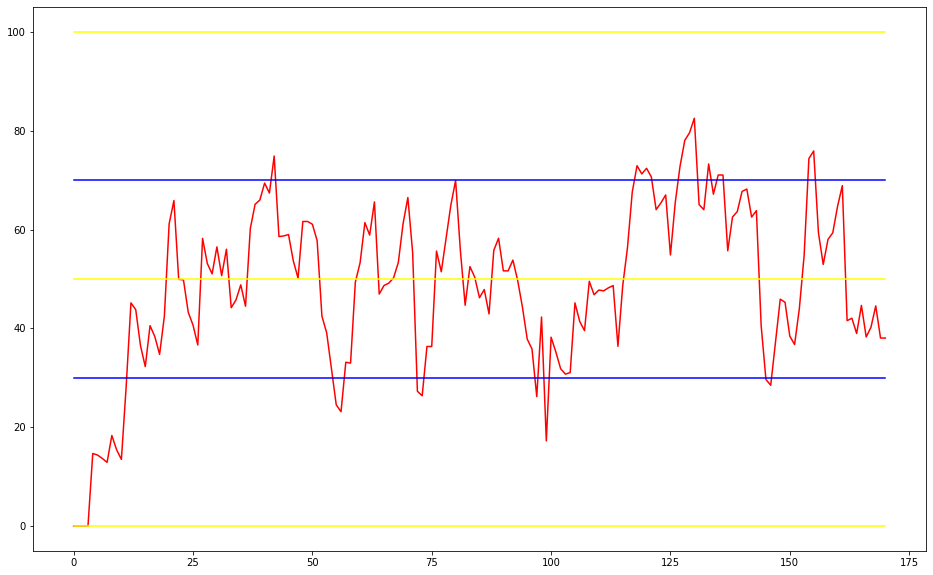

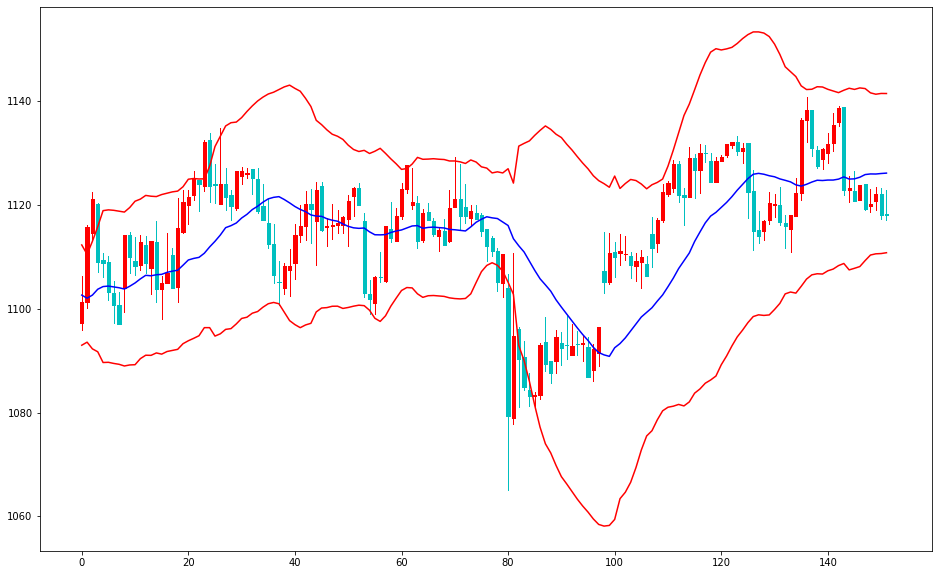

In [1275]:
# plot
plt.subplots(figsize=(16,10))
plt.plot(RSI.RSI, color='red')
plt.plot(RSI['0'], color='yellow')
plt.plot(RSI['30'], color='blue')
plt.plot(RSI['50'], color='yellow')
plt.plot(RSI['70'], color='blue')
plt.plot(RSI['100'], color='yellow')

fig, ax = plt.subplots(figsize=(16,10))
candlestick2_ohlc(ax, prices.Open, prices.High, prices.Low, prices.Close,
                  width=0.6, colorup='r', colordown='c', alpha=1)
plt.plot(Bolbands.ML, color='blue')
plt.plot(Bolbands.BL, color='red')
plt.plot(Bolbands.TL, color='red')